## Inclinations with PyStan

I hope you find this useful! This is the notebook we used to infer inclinations for the Pleiades stars in White et al., MNRAS 2017. Please modify this as you see fit for your own use, no need for citation, but please do mention it at least in the acknowledgements. GPL v3 License. 

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib as mpl
mpl.style.use('seaborn-colorblind') # equality of access is important!

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math, display

import pystan

Load the data.

In [5]:
names = ['CR Dra']

day2sec = 24.*3600.
rsun = 695700
teff = 4128 # J/A+A/615/A31/table2 Post annotation PTPS stars IV. (Deka-Szymankiewicz+, 2018) - but which component?
r =  np.array([2.094 * (teff/5777) - 0.936 ])*rsun # https://arxiv.org/pdf/1905.03623.pdf

f = np.array([1./1.99])/day2sec
sig_f = 0.001*f#np.array([0.002])/day2sec
print(f)
vsini = np.array([17.36]) # from simbad - CARMENES input catalogue of M dwarfs. III. (Jeffers+, 2018)
sig_vsini = np.array([0.55]) # from simbad

# r = np.array([0.72])*rsun # from gaia
sig_r = np.array([0.05])*rsun # from gaia
print(r)

N = len(f)

data = dict(mu_f=f,sig_f=sig_f,vsini=vsini, sig_vsini=sig_vsini,mu_r=r,sig_r=sig_r,N=N)

[5.81611763e-06]
[389789.49835555]


In [6]:
model_code = """
data {
    int<lower=0> N;           // number of datasets
    
    real<lower=0> mu_f[N];
    real<lower=0> sig_f[N];
    
    real<lower=0> vsini[N];
    real<lower=0> sig_vsini[N];
    
    real<lower=0> mu_r[N];
    real<lower=0> sig_r[N];
}

parameters {
    real<lower=0> f[N];
    real<lower=0> r[N];
    real<lower=0,upper=90> i[N];
}

transformed parameters {
    real cosi[N];
    for (n in 1:N) {
        cosi[n] <- cos(i[n]*pi()/180);
        }
}

model {
    for (n in 1:N) {
        f[n] ~ normal(mu_f[n], sig_f[n]);
        r[n] ~ normal(mu_r[n], sig_r[n]);
        cosi[n] ~ uniform(0,1);
        vsini[n] ~ normal(r[n] * 2 * pi() * f[n] * sin(i[n]*pi()/180), sig_vsini[n]);
        }
}
"""

In [7]:
model = pystan.StanModel(model_code=model_code) 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eaf6a1c4cfd53b432ff870ce6f63cd3b NOW.


In [8]:
fit = model.sampling(data=data, iter=20000, chains=4)

In [9]:
results = fit.extract()

In [10]:
mua = (np.mean(results["i"][10000:,:],axis=0), np.std(results["i"][10000:,:],axis=0))


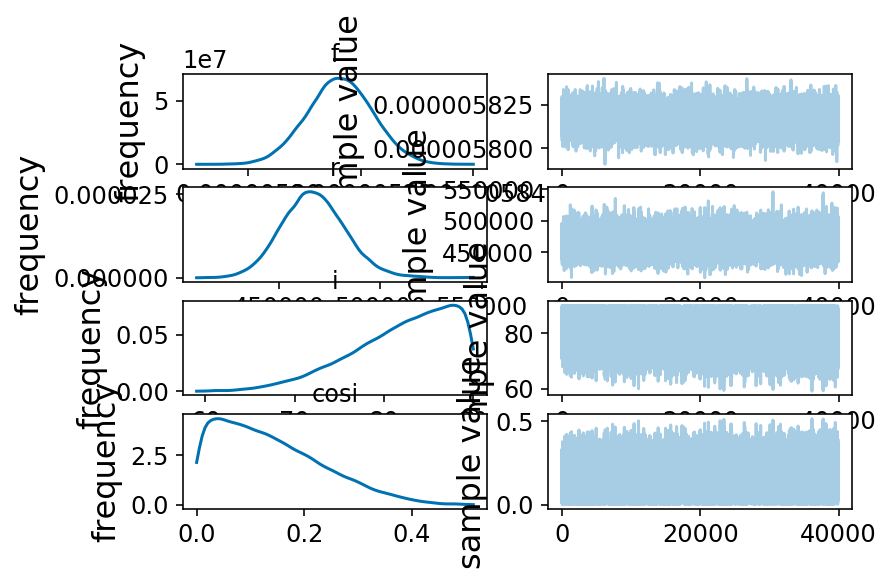

In [11]:
fit.plot();

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if __name__ == '__main__':


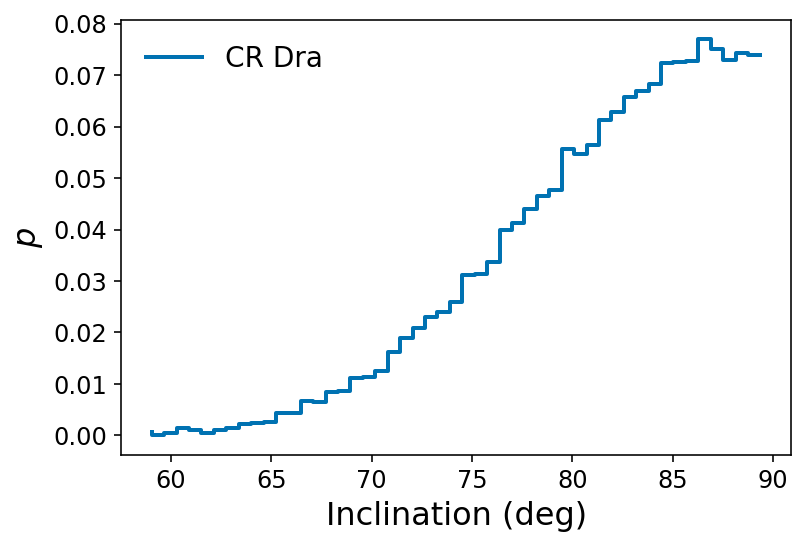

In [12]:
ax = plt.axes()
# change as you see fit
vermilion = ((213.,94.,0.))
vermilion = (213/sum(vermilion),94/sum(vermilion),0)
verm = mpl.colors.rgb2hex(vermilion) # get alcyone colour

j = 0

vals, bins = np.histogram(results["i"][10000:,j],bins=50,normed=True)
plt.step(bins[:-1],vals,label=names[j],lw=2)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1], labels[::-1],fontsize=14,frameon=False)

plt.xlabel(r'Inclination (deg)')
plt.ylabel(r'$p$')
plt.savefig('cr_dra_inclinations.png')
plt.savefig('cr_dra_inclinations.eps')

In [11]:
# tosave = {names[0]:results['i'][:,0],
#           names[1]:results['i'][:,1],
#           names[2]:results['i'][:,2]}
# print tosave
# from astropy.table import Table
# stuff = Table(tosave)
# stuff.write('pleione_maia_alcyone_incs.csv')

In [13]:
r/rsun

array([0.56028388])